In [1]:
# %%
import numpy as np
from scipy.linalg import svd
import sys
sys.path.append("../")
import scipy.io as sio
import os
import matplotlib.pyplot as plt

In [2]:
import h5py
with h5py.File('pressure_data.mat', 'r') as file:
    # Load DATA_U and transpose it
    DATA = np.array(file['/DATA']).T  # Transpose the data
print("size of DATA: ", DATA.shape)

size of DATA:  (798, 295122)


In [3]:
# %%
# Load the MAT file

# Define the number of singular values/components to keep
k = 150  # for example, keep 150 components

# Perform SVD and keep only the first k of U, S, and VT
# Perform SVD decomposition
U, S, VT = svd(DATA, full_matrices=False)
U_reduced = U[:, :k]
S_reduced = S[:k]
VT_reduced = VT[:k, :]



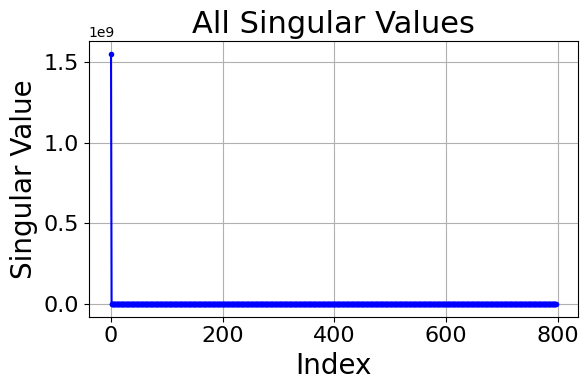

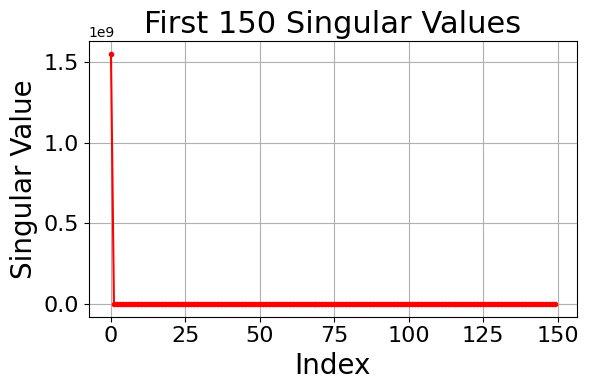

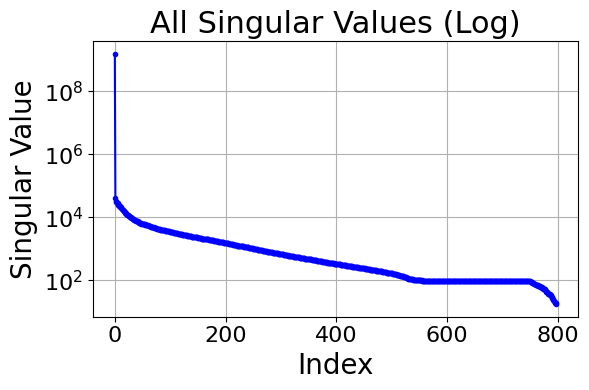

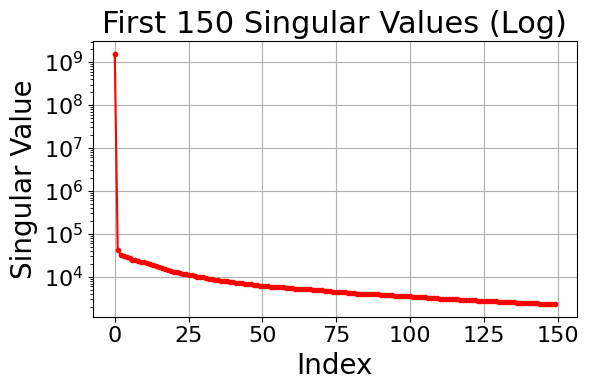

In [6]:
# Figure 1: All singular values on linear scale
plt.figure(figsize=(6, 4))
plt.plot(S, 'bo-', markersize=3)
plt.title('All Singular Values', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Singular Value', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label size
plt.grid(True)
plt.tight_layout()

# Figure 2: First k singular values on linear scale
plt.figure(figsize=(6, 4))
plt.plot(S[:k], 'ro-', markersize=3)
plt.title(f'First {k} Singular Values', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Singular Value', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label size
plt.grid(True)
plt.tight_layout()

# Figure 3: All singular values on log scale
plt.figure(figsize=(6, 4))
plt.semilogy(S, 'bo-', markersize=3)
plt.title('All Singular Values (Log)', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Singular Value', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label size
plt.grid(True)
plt.tight_layout()

# Figure 4: First k singular values on log scale
plt.figure(figsize=(6, 4))
plt.semilogy(S[:k], 'ro-', markersize=3)
plt.title(f'First {k} Singular Values (Log)', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Singular Value', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label size
plt.grid(True)
plt.tight_layout()

# Display all figures
plt.show()

In [14]:
# Reconstruct the reduced data matrix
DATA_reduced = np.dot(U_reduced, np.diag(S_reduced))

# Now you can slice the DATA as before
X = DATA_reduced[:-1]  # All rows except the last
Y = DATA_reduced[1:]   # All rows except the first

print("size of DATA reduced: ", DATA_reduced.shape)
print("size of X: ", X.shape)
# Clean up
# del temp

len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all),:]
data_x_valid = X[int(0.7*len_all)+1:,:]

data_y_train = Y[:int(0.7*len_all),:]
data_y_valid = Y[int(0.7*len_all)+1:,:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

size of DATA reduced:  (798, 150)
size of X:  (797, 150)


In [7]:
# %%
from solver_resdmd_tf import KoopmanNN, KoopmanSolver

# basis_function = PsiNN(layer_sizes=[100,100,100], n_psi_train=n_psi_train)
# N_dict = n_psi_train + 3
# # Dynamically import the solver module based on solver_index
# filename = f'solver_{solver_index}_outputs_{N_dict}basis.mat'
# solver_module = __import__(f"solver_{solver_index}", fromlist=['KoopmanDLSolver'])
# KoopmanDLSolver = getattr(solver_module, 'KoopmanDLSolver')
n_psi=99
basis_function = KoopmanNN(layer_sizes=[120,120,120], n_psi_train=n_psi)

# Using the dynamically imported solver
solver = KoopmanSolver(dic=basis_function, 
                            target_dim=np.shape(data_train)[-1], 
                            reg=0.1)
solver.build(data_train=data_train, 
                data_valid=data_valid, 
                epochs=100, 
                batch_size=500, 
                lr=1e-4, 
                log_interval=10, 
                lr_decay_factor=.8)

# Results from solver
evalues = solver.eigenvalues
efuns_X = solver.eigenfunctions(X)
efuns_Y = solver.eigenfunctions(Y)
N_dict = np.shape(evalues)[0]    
Psi_X = solver.get_Psi_X().numpy()
Psi_Y = solver.get_Psi_Y().numpy()
# Koopman_matrix_K = solver.K.numpy()
# kpm_modes = solver.compute_mode()
kpm_modes = np.dot(VT_reduced.T, solver.compute_mode())

# Prepare data to save
outputs = {
    'evalues': evalues,
    'efuns_X': efuns_X,
    'efuns_Y': efuns_Y,
    'N_dict': N_dict,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    # 'K': Koopman_matrix_K,
    'kpm_modes': kpm_modes,
}

Outer Epoch 1/100
Epoch 1/2
2/2 [==============================] - 1s 317ms/step - loss: 192.8891 - val_loss: 45433.7457
Epoch 2/2
2/2 [==============================] - 0s 29ms/step - loss: 192.8892 - val_loss: 45433.7464
Outer Epoch 2/100
Epoch 1/2
2/2 [==============================] - 0s 56ms/step - loss: 192.8892 - val_loss: 45433.7472
Epoch 2/2
2/2 [==============================] - 0s 30ms/step - loss: 192.8892 - val_loss: 45433.7480
Outer Epoch 3/100
Epoch 1/2
2/2 [==============================] - 0s 63ms/step - loss: 192.8892 - val_loss: 45433.7474
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 192.8892 - val_loss: 45433.7469
Outer Epoch 4/100
Epoch 1/2
2/2 [==============================] - 0s 56ms/step - loss: 192.8892 - val_loss: 45433.7471
Epoch 2/2
2/2 [==============================] - 0s 28ms/step - loss: 192.8892 - val_loss: 45433.7477
Outer Epoch 5/100
Epoch 1/2
2/2 [==============================] - 0s 68ms/step - loss: 192.8892 - val_loss: 45

In [8]:
print(efuns_X.shape)
print(efuns_Y.shape)

(797, 250)
(797, 250)


In [9]:
folder_path = 'data/turbulence_data'  # Adjust the path as needed if you want a different location
os.makedirs(folder_path, exist_ok=True)
# Save the outputs to a .mat file named according to the number of basis functions, inside the "data" folder
file_path = os.path.join(folder_path, f'turbulence_resdmd_{N_dict}basis.mat')
sio.savemat(file_path, outputs)
print(f'Saved outputs for n_psi_train={n_psi} to {file_path}')

Saved outputs for n_psi_train=99 to data/turbulence_data\turbulence_resdmd_250basis.mat
